# Model Buliding

## Dependencies

In [1]:
import os 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
import pickle

## Importing Data

In [2]:
train = "./data"
content = sorted(os.listdir(train))

# Total no of Classes 
no_of_classes = len(content)

# Create a dictionary for find in out
content_dict = {index: value for index, value in enumerate(content)}
print(content_dict)

# Save dictionary for inferance to access
with open('content_dict.pickle', 'wb') as f:
    pickle.dump(content_dict, f)

{0: 'Aboard', 1: 'Afternoon', 2: 'Again', 3: 'Anger', 4: 'Archery', 5: 'Arrest', 6: 'Ascend', 7: 'Assertive', 8: 'Attedance', 9: 'Auditorium', 10: 'Awake', 11: 'Baby', 12: 'Back', 13: 'Bad', 14: 'Bath', 15: 'Beautiful', 16: 'Beside', 17: 'Bhutan', 18: 'Big', 19: 'Bird', 20: 'Biscuit', 21: 'Blunt', 22: 'Born', 23: 'Bowl', 24: 'Break', 25: 'Bribe', 26: 'Brush', 27: 'Call', 28: 'Careful', 29: 'Catch', 30: 'Cheap', 31: 'Child', 32: 'Church', 33: 'Close', 34: 'Comb', 35: 'Communist_Party', 36: 'Confused', 37: 'Cool', 38: 'Coolie', 39: 'Corruption', 40: 'Crab', 41: 'Crane', 42: 'Crooked', 43: 'Cut', 44: 'Dark', 45: 'Day', 46: 'Delete', 47: 'Denmark', 48: 'Die', 49: 'Difficult', 50: 'Discuss_Throw', 51: 'Drink', 52: 'Dry', 53: 'Egypt', 54: 'Empty', 55: 'Enemy', 56: 'Enjoy', 57: 'Enter', 58: 'Facebook', 59: 'Faith', 60: 'Fall', 61: 'Fast', 62: 'File', 63: 'Finish', 64: 'Float', 65: 'Follow', 66: 'Food', 67: 'Fork', 68: 'France', 69: 'Friend', 70: 'Front', 71: 'Full', 72: 'Future', 73: 'Germany

## Image Data Augmentation

In [3]:
data_generator = ImageDataGenerator(
    samplewise_center = True, 
    samplewise_std_normalization = True,
    brightness_range = [0.8, 1.0], # for images are so bright or in dark
    zoom_range = [1.0, 1.2], # for small to normal size for hand detection
    validation_split = 0.1, # Standard value to prevent overfitting
    # Additional parameter for improving image handling
    horizontal_flip = True,  # Added horizontal flip for symmetry
    vertical_flip = True,  # Added vertical flip for additional variation
    rotation_range = 20,  # Added rotation for orientation variation
    shear_range = 0.2  # Added shear transformation for perspective variation
)


# Generate data from the training directory
train_generator = data_generator.flow_from_directory(
    train, 
    target_size = (200,200), # Resize images to 300x300p from 640x480p Target size according to image size
    shuffle = True, 
    seed = 13,
    class_mode = 'categorical', 
    batch_size = 64,
    subset="training"
)

validation_generator = data_generator.flow_from_directory(
    train, 
    target_size = (200, 200), 
    shuffle = True, 
    seed = 13,
    class_mode = 'categorical', 
    batch_size = 64, 
    subset = "validation"
)

Found 7031 images belonging to 199 classes.
Found 778 images belonging to 199 classes.


## Transfer Learning based Model Training

In [4]:
inception_v3 = InceptionV3(
    input_shape = (200, 200, 3), 
    include_top = False, 
    weights = 'imagenet' # Do not load imagenet weights; use custom weights instead
)
inception_v3.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 99, 99,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 99, 99,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 99, 99,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 97, 97,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 97, 97,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 97, 97,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 97, 97,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 97, 97,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 97, 97,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 46, 46,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 46, 46,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 46, 46,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [5]:
inception_output_layer = inception_v3.get_layer('mixed7')
print('Inception model output shape:', inception_output_layer.output.shape)

inception_output = inception_v3.output

Inception model output shape: (None, 10, 10, 768)


In [6]:
# Add dropout and L2 regularization to the new layers
x = GlobalAveragePooling2D()(inception_output)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x) 
x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting
x = Dense(no_of_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

model = Model(inception_v3.input, x) 

# Compile the model with Adam optimizer and dynamic learning rate adjustment
model.compile(
    # optimizer = SGD(learning_rate=0.0001, momentum=0.9), # SGD has fix learning rate 
    # for fine-tuning use Adam which automatically adjusts the learning rate 
    optimizer = Adam(learning_rate=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

## Callback Function For Model Training

In [7]:
LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.95

class ModelCallback(tf.keras.callbacks.Callback):
  # shows validation loss and validation accuracy at end of each iteration / epoch
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

In [8]:
# To prevent overfitting
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [9]:
# Dynamically adjust the learning rate based on the model's performance
lr_scheduler = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 0.00001)

## Train Model

In [10]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 200,
    validation_steps = 50,
    epochs = 50,
    callbacks = [early_stopping,callback,lr_scheduler] # 
)

Epoch 1/50


c:\Sing2Voice\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/200 ━━━━━━━━━━━━━━━━━━━━ 1:27 977ms/step - accuracy: 0.0073 - loss: 5.3821

C:\Users\Harsh\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


200/200 ━━━━━━━━━━━━━━━━━━━━ 132s 608ms/step - accuracy: 0.0082 - loss: 5.3663 - val_accuracy: 0.0129 - val_loss: 5.3108
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2176s 11s/step - accuracy: 0.0207 - loss: 5.1863 - val_accuracy: 0.0398 - val_loss: 5.0955
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 122s 594ms/step - accuracy: 0.0569 - loss: 5.0254 - val_accuracy: 0.0720 - val_loss: 4.9580
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 605ms/step - accuracy: 0.1304 - loss: 4.8524 - val_accuracy: 0.1272 - val_loss: 4.7871
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 602ms/step - accuracy: 0.2133 - loss: 4.6765 - val_accuracy: 0.2095 - val_loss: 4.6395
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 125s 604ms/step - accuracy: 0.2945 - loss: 4.5059 - val_accuracy: 0.2776 - val_loss: 4.4820
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 601ms/step - accuracy: 0.3729 - loss: 4.3174 - val_accuracy: 0.3406 - val_loss: 4.3160
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 126s 612ms/step - accuracy: 0.4451 - loss: 4.127

## Save Model

In [11]:
model.save('my_model.keras')

## Evaluation Metrics

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

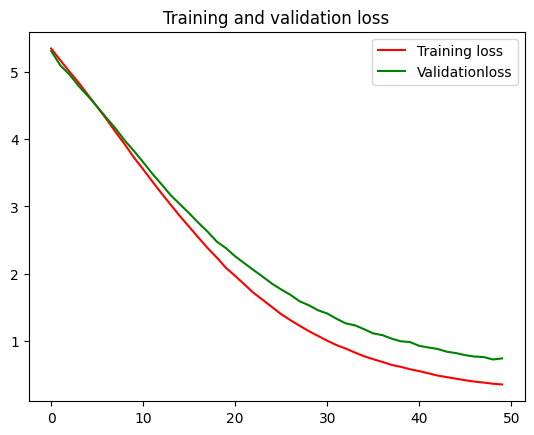

<Figure size 640x480 with 0 Axes>

In [14]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

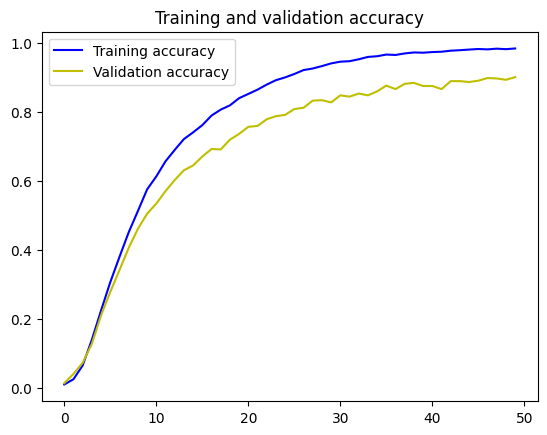

<Figure size 640x480 with 0 Axes>

In [15]:
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()